# AUTOENCODER

Library imports

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pylab as plt
import tqdm as tqdm #overhead of 60ns

Function to plot image

In [2]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray_r')

Creation of class Autoencoder

In [3]:
class Autoencoder (nn.Module):

    def __init__(self, en_out1=32, en_out2=64, en_out3=64, en_out4=64, dec_out1=64, dec_out2=64, dec_out3=32):
        super(Autoencoder, self).__init__()
        #Encoder parameters
        self.en_conv1 = nn.Conv2d(in_channels=1, out_channels=en_out1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(en_out1)
        self.en_conv2 = nn.Conv2d(in_channels=en_out1, out_channels=en_out2, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(en_out2)
        self.en_conv3 = nn.Conv2d(in_channels=en_out2, out_channels=en_out3, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(en_out3)
        self.en_conv4 = nn.Conv2d(in_channels=en_out3, out_channels=en_out4, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(en_out4)
        self.lin1 = nn.Linear(en_out4*7*7, 2)
        
        #Decoder parameters
        self.lin2 = nn.Linear(2, en_out4*7*7)
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=en_out4, out_channels=dec_out1, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(dec_out1)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=dec_out1, out_channels=dec_out2, kernel_size=3, stride=2, padding=1,
                                            output_padding=1)
        self.bn6 = nn.BatchNorm2d(dec_out2)
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=dec_out2, out_channels=dec_out3, kernel_size=3, stride=2, padding=1,
                                            output_padding=1)
        self.bn7 = nn.BatchNorm2d(dec_out3)
        self.dec_conv4 = nn.ConvTranspose2d(in_channels=dec_out3, out_channels=1, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.25)
    
    def encoder(self, x):
        x = self.dropout(self.bn1(torch.relu(self.en_conv1(x))))
        x = self.dropout(self.bn2(torch.relu(self.en_conv2(x))))
        x = self.dropout(self.bn3(torch.relu(self.en_conv3(x))))
        x = self.dropout(self.bn4(torch.relu(self.en_conv4(x))))
        x = x.view(x.size(0), -1)
        latent_space = self.lin1(x)
        
        return latent_space
    
    def decoder(self, latent_space):
        x = self.lin2(latent_space)
        x = x.view(x.size(0), 64, 7, 7)
        x = self.dropout(self.bn5(torch.relu(self.dec_conv1(x))))
        x = self.dropout(self.bn6(torch.relu(self.dec_conv2(x))))
        x = self.dropout(self.bn7(torch.relu(self.dec_conv3(x))))
        x = torch.relu(self.dec_conv4(x))
        
        return x

    def forward(self, x):
        latent_space = self.encoder(x)
        x = self.decoder(latent_space) 

        return x


### Download dataset
MNIST dataset download and plotting of the data

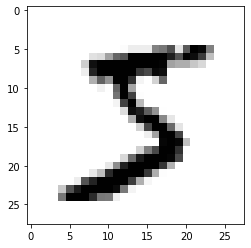

In [4]:
bs = 512
# Download train & validation dataset
train_ds = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
validation_ds = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# The label for the fourth data element
train_ds[3][1]

# The image for the fourth data element
plt.figure()
show_data(train_ds[0])

### Model, criterion and optimizer initilization

In [5]:
# ----------------------------------------------- DEFINE MODEL --------------------------------------------------------#
device = torch.device('cuda')
model = Autoencoder(en_out1=32, en_out2=64, en_out3=64, en_out4=64, dec_out1=64, dec_out2=64, dec_out3=32)
model.cuda(device)

# ------------------------------------------- CRITERION & OPTIMIZER ---------------------------------------------------#
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(.9, .99), weight_decay=1e-2)

train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=512)
validation_loader = torch.utils.data.DataLoader(dataset=validation_ds, batch_size=5000)

### Training

In [6]:
# ------------------------------------------------ TRAINING ----------------------------------------------------------#
torch.set_grad_enabled(True)

n_epochs = 20
cost_list = []
COST = 0

for epoch in tqdm.tqdm(range(n_epochs)):
    COST = 0
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(.9, .99), weight_decay=1e-2)
    for i, data in enumerate(train_loader):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        z = model.forward(img)
        loss = criterion(z, img)
        loss.backward()
        optimizer.step()
        COST += loss.data
        if i % 33 == 0:
            print(loss)

    cost_list.append(COST)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

tensor(6.2565, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3318, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1365, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1039, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|████                                                                              | 1/20 [03:01<57:30, 181.61s/it]

tensor(0.0887, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0870, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0783, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0738, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|████████▏                                                                         | 2/20 [06:03<54:32, 181.83s/it]

tensor(0.0720, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0723, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0882, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0702, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|████████████▎                                                                     | 3/20 [09:02<51:15, 180.90s/it]

tensor(0.0667, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0683, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0622, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0595, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|████████████████▍                                                                 | 4/20 [10:54<42:41, 160.12s/it]

tensor(0.0606, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0618, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0578, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0566, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|████████████████████▌                                                             | 5/20 [13:00<37:27, 149.85s/it]

tensor(0.0632, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0991, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0715, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0675, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|████████████████████████▌                                                         | 6/20 [14:43<31:42, 135.87s/it]

tensor(0.0639, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0647, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0598, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0608, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|████████████████████████████▋                                                     | 7/20 [16:38<28:05, 129.65s/it]

tensor(0.0571, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0610, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0563, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0581, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████████████████████████████████▊                                                 | 8/20 [18:40<25:28, 127.38s/it]

tensor(0.0545, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0562, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0537, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0550, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████████████████████████████████████▉                                             | 9/20 [20:37<22:44, 124.09s/it]

tensor(0.0538, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0503, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0550, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████████████████████████████████████████▌                                        | 10/20 [22:26<19:57, 119.73s/it]

tensor(0.0516, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0523, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0516, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|████████████████████████████████████████████▌                                    | 11/20 [24:07<17:07, 114.18s/it]

tensor(0.0476, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0509, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0517, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|████████████████████████████████████████████████▌                                | 12/20 [25:43<14:29, 108.73s/it]

tensor(0.0465, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0503, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0502, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|████████████████████████████████████████████████████▋                            | 13/20 [27:35<12:47, 109.59s/it]

tensor(0.0457, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0455, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [29:29<11:04, 110.79s/it]

tensor(0.0450, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0491, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0450, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [31:39<09:44, 116.83s/it]

tensor(0.0446, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0487, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0449, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0484, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [33:20<07:27, 111.91s/it]

tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0487, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0439, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0480, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [34:58<05:23, 107.84s/it]

tensor(0.0452, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0482, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0442, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0492, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [36:36<03:29, 104.95s/it]

tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0479, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0440, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [38:22<01:45, 105.07s/it]

tensor(0.0444, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0478, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0437, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0481, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [40:12<00:00, 120.60s/it]


### Analysis 
Here 5 input samples and 5 reconstructed output are shown. 

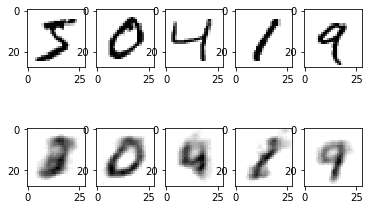

In [7]:
# ------------------------------------------------ ANALYSIS ----------------------------------------------------------#
torch.set_grad_enabled(False)

analysis_loader = iter(train_ds)

for i in range(5):

    example = next(analysis_loader)
    z_points = example[0].to(device)
    z_points = model.encoder(example[0].unsqueeze(0).to(device))
    reconst_imgs = model.decoder(z_points)
    x, y = example[0], example[1]
    
    plt.subplot(2,5,i+1)
    img = x.squeeze()
    plt.imshow(img, cmap='gray_r')
    
    plt.subplot(2,5,i+5+1)
    img = reconst_imgs.cpu().squeeze()
    img = img.detach().numpy()
    plt.imshow(img, cmap='gray_r')


We can appreciate that some of the numbers are not well reconstructed. We are going to plot the latent space in order to have a better understanding of what is happening.

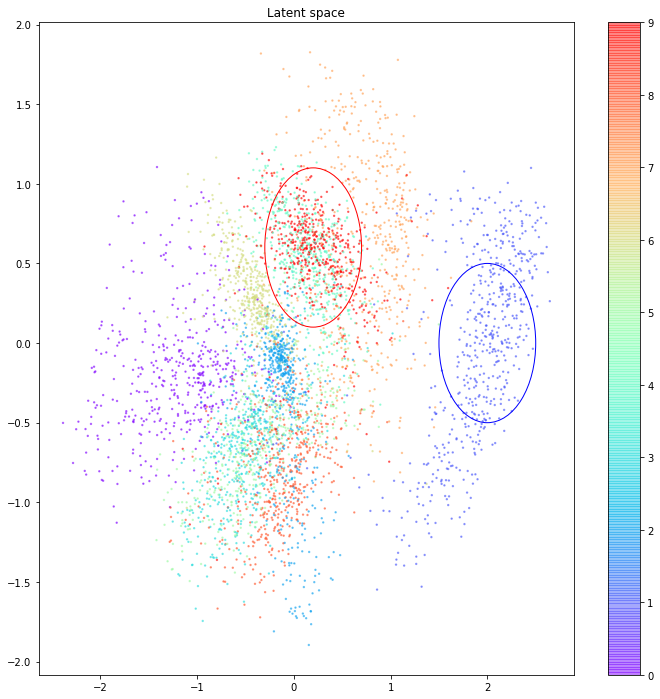

In [15]:
validation_dl = torch.utils.data.DataLoader(dataset=validation_ds, batch_size=5000, shuffle=False, drop_last=True)

figsize = 12
np.random.seed(42)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

examples = next(iter(validation_dl))
x, y = examples[0], examples[1]
z_points = model.encoder(x.to(device)).cpu()

# Circle declarations
circle1 = plt.Circle((0.2, 0.6), 0.5, color='r', fill=False)
circle2 = plt.Circle((2, 0), 0.5, color='b', fill=False)

# Whole latent space
plt.figure(figsize=(figsize, figsize))
plt.title('Latent space')
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()
plt.gcf().gca().add_artist(circle1)
plt.gcf().gca().add_artist(circle2)


Taking a look to the scatterplot we are going to focus on two zones of the latent space in order to understand what is happening.

We can see in the reed circle how number 3 shares the same space as number 8 because of their similarity. Therefore if we want to generate a 3 or an 8 it is not going to be possible.

However, we perceibe in the blue circle how digit 1 has its own space. In this case we are going to be able to reconstruct a 1 digit from the latent space.

We are going to porve this by taking a point from the red circle and one form the blue circle:

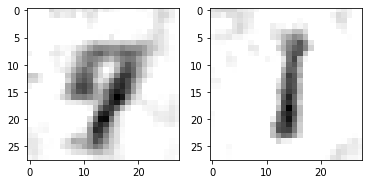

In [22]:
z = torch.tensor([[2.5, 0],[0.7,0.2]])
reconst_img = model.decoder(z.to(device))
reconst_img = reconst_img.cpu().squeeze()

plt.subplot(1,2,1)
plt.imshow(reconst_img[1], cmap='gray_r')

plt.subplot(1,2,2)
plt.imshow(reconst_img[0], cmap='gray_r')

As we can see from the plots we could not reconstruct a digit form the red circle but we achieved a good generation of digit 1. To solve this problem we need to implement a varioational autoencoder.